In [1]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping


from matplotlib import pyplot as plt

D:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import numpy as np
np.random.seed(1337) # for reproducibility

data_generator = ImageDataGenerator(rescale=1./255,
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = 0.3,
width_shift_range = 0.3,
height_shift_range=0.3,
rotation_range=30, validation_split=0.2)

train_generator = data_generator.flow_from_directory('Dataset', target_size=(256, 256), shuffle=True, seed=13,
                                                     class_mode='categorical', batch_size=24, subset="training")

validation_generator = data_generator.flow_from_directory('Dataset', target_size=(256, 256), shuffle=True, seed=13,
                                                     class_mode='categorical', batch_size=24, subset="validation")

Found 8586 images belonging to 151 classes.
Found 2071 images belonging to 151 classes.


In [3]:
img_width, img_height = 256, 256
nb_train_samples = 8586
nb_validation_samples = 2071
batch_size = 24
epochs = 20

In [4]:
model = applications.VGG19(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))

In [5]:
# Freezing the layers which I don't want to train.
for layer in model.layers[:5]:
    layer.trainable = False

In [6]:
# Adding custom Layers 
x = model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(151, activation="softmax")(x)

# creating the final model 
model_final = Model(input = model.input, output = predictions)

# compile the model 
model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])


In [6]:
model_final.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

In [7]:
# Save the model according to the conditions  
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=5)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')
#to stop if model stops improving

In [ ]:
# Train the model 
model.fit_generator(
train_generator,
steps_per_epoch = nb_train_samples//batch_size,
epochs = epochs,
validation_data = validation_generator,
validation_steps=nb_validation_samples//batch_size,
callbacks = [checkpoint,early])


In [10]:
[val_loss,val_acc]=model.evaluate_generator(validation_generator)

D:\Anaconda\lib\site-packages\PIL\Image.py:931: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


In [11]:
print(val_acc)

0.759053596202329


In [6]:

data_generator2 = ImageDataGenerator(#rescale=1./255,
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = 0.3,
width_shift_range = 0.3,
height_shift_range=0.3,
rotation_range=30, validation_split=0.2)

train_generator2 = data_generator.flow_from_directory('Dataset', target_size=(256, 256), shuffle=False, seed=13,
                                                     class_mode='categorical', batch_size=24, subset="training")

validation_generator2 = data_generator.flow_from_directory('Dataset', target_size=(256, 256), shuffle=False, seed=13,
                                                     class_mode='categorical', batch_size=24, subset="validation")

Found 8586 images belonging to 151 classes.
Found 2071 images belonging to 151 classes.


In [7]:
fnames = validation_generator2.filenames
 
ground_truth = validation_generator2.classes
 
label2index = validation_generator2.class_indices
 
# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())
prob = model.predict_generator(validation_generator2)
predictions=np.argmax(prob,axis=1)

errors = np.where(predictions != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),nb_validation_samples))

D:\Anaconda\lib\site-packages\PIL\Image.py:931: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


No of errors = 502/2071


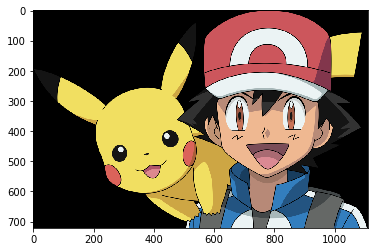

It is a Pikachu!
Prediction: Pikachu with confidence of 99.98%


In [58]:
a=1400
poke=load_img('{}/{}'.format('Dataset',fnames[a]))
plt.imshow(poke)
plt.show()
print("It is a "+fnames[a].partition("\\")[0]+"!")
print("Prediction: "+idx2label[predictions[a]]+" with confidence of "+"{:.2f}".format(np.max(prob,axis=1)[a]*100)+"%" )